In [57]:
import pandas as pd
from glob import glob
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

In [58]:
# jsons = glob("data/simulation/*/result.json")
all_refinements = []
data = []
for i in range(0, 1000):
    if os.path.exists(f"data/simulation/virtual customer {i}/result.json"):
        with open(f"data/simulation/virtual customer {i}/result.json") as f:
            s = json.load(f)
            s['succeed'] = True
            s['group'] = 'T1' if i  % 2 == 0 else 'C'
            if 'price' in s:
                price = s["price"].replace("$", "").replace("\n", "").replace(",", "")
                if price.count(".") != 1:
                    print(price)
                    price = price[: len(price)//2]
                s["price"] = float(price)
            else:
                s['price'] = 0
            if os.path.exists(f"data/simulation/virtual customer {i}/action_trace.txt"):
                s['action'] = [json.loads(x) for x in open(f"data/simulation/virtual customer {i}/action_trace.txt").readlines()]
                s['flatten_action'] = [item for sublist in s['action'] for item in sublist]
                s['len_action'] = sum([len(x) for x in s['action']])
                s['num_click'] = sum([x['type'] == 'click' for x in s['flatten_action']])
                s['num_search'] = sum([x['type'] == 'type_and_submit' for x in s['flatten_action']])
                s["num_click_refinements"] = sum(
                    [
                        x["type"] == "click" and x["name"].startswith("refinements")
                        for x in s["flatten_action"]
                    ]
                )
                s["num_click_search_results"] = sum(
                    [
                        x["type"] == "click" and x["name"].startswith("search_results")
                        for x in s["flatten_action"]
                    ]
                )
                s["action_valid"] = sum(
                    [
                        # "type": "click", "name": "add_to_cart.buy_now"
                        x["type"] == "click" and x["name"] == "add_to_cart.buy_now"
                        for x in s["flatten_action"]
                    ]
                ) == 1
            persona = json.load(open(f"data/personas/json/virtual customer {i}.json"))
            s['persona'] = persona
            s['gender'] = persona['gender']
            s['income'] = persona['income']
            s['age'] = persona['age']
            s['intent'] = persona['intent']
            if s["income"] == [0, 30000]:
                s["income_group"] = "low"
            elif s["income"] == [30001, 94000]:
                s["income_group"] = "middle"
            elif s["income"] == [94001, 1000000]:
                s["income_group"] = "high"
            else:
                s["income_group"] = "unknown"
            # pages
            refinements_impressions = []
            pages = glob(f"data/simulation/virtual customer {i}/page_*.html")
            for page in pages:
                # use regex to find all <a name="refinements.[^\.]+
                with open(page) as f:
                    html = f.read()
                    # import re  re.findall(r'<a name="refinements.([^\.]+)', html)
                    for refinement_name in re.findall(r'<a name="refinements.([^\.]+)', html):
                        refinements_impressions.append(refinement_name)
                    # <li name="refinements.brands
                    for refinement_name in re.findall(r'<li name="refinements.([^\.]+)', html):
                        refinements_impressions.append(refinement_name)
            s['num_pages'] = len(pages)
            for refinement_name in set(refinements_impressions):
                s["refinement_impression_" + refinement_name] = refinements_impressions.count(refinement_name)
            for refinement_name in set(refinements_impressions):
                s["refinement_click_" + refinement_name] = sum(
                    [
                        x["type"] == "click" and x["name"].startswith("refinements." + refinement_name)
                        for x in s["flatten_action"]
                    ]
                )
            all_refinements += [
                action for action in s["flatten_action"] if action['type'] == 'click' and  action["name"].startswith("refinements.")
            ]
            data.append(s)
    else:
        s = {
                "succeed": False,
                "group": "T1" if i % 2 == 0 else "C",
                "price": 0,
                "terminated": False,
            }
        persona = json.load(open(f"data/personas/json/virtual customer {i}.json"))
        s['persona'] = persona
        s['gender'] = persona['gender']
        s['income'] = persona['income']
        s['age'] = persona['age']
        s['intent'] = persona['intent']
        if s['income'] == [0, 30000]:
            s['income_group'] = 'low'
        elif s['income'] == [30001, 94000]:
            s['income_group'] = 'middle'
        elif s['income'] == [94001, 1000000]:
            s['income_group'] = 'high'
        else:
            s['income_group'] = 'unknown'
        data.append(s
        )

449.99449.99


In [71]:
df = pd.DataFrame(data)
df.loc[df["terminated"].isnull(), "terminated"] = False
df['terminated'] = df['terminated'].astype(bool)
df['succeed'] = df['succeed'].astype(bool)
df['error'] = (~df['terminated']) & (df['price'] == 0)
# swap treatment and control
df['group'] = df['group'].apply(lambda x: 'T1' if x == 'C' else 'C')
df.fillna(0, inplace=True)

df["all_refinements_impression"] = sum(
    [df[column] for column in df.columns if column.startswith("refinement_impression_")]
)
df['all_refinements_impression_per_page'] = df['all_refinements_impression'] / df['num_pages']
df["num_click_refinements_per_page"] = df["num_click_refinements"] / df["num_pages"]
df["num_refinements_click_per_impression"] = (
    df["num_click_refinements"] / df["all_refinements_impression"]
)
df["num_refinements_click_per_impression_per_page"] = (
    df["num_click_refinements"] / df["all_refinements_impression_per_page"]
)


In [50]:
# [i for i in df.columns if i.startswith("refinement_click_")]
sum([df[column] for column in df.columns if column.startswith("refinement_click_")])

np.float64(518.0)

In [76]:
df[df["group"] == "C"]["num_refinements_click_per_impression_per_page"].mean()

np.float64(0.09491966500797207)

In [77]:
df[df["group"] == "T1"]["num_refinements_click_per_impression_per_page"].mean()


np.float64(0.09580227839256347)

In [107]:
def stat(ndf):
    print("control: ", (ndf[df["group"] == "C"]).mean())
    print("treatment: ", (ndf[df["group"] == "T1"]).mean())

stat(
    df["num_click_refinements"]
    / (df["all_refinements_impression"] / df["num_pages"])
)
stat(df["num_click_refinements"])

control:  0.09491966500797207
treatment:  0.09580227839256347
control:  0.546
treatment:  0.506


np.float64(14.912)

In [95]:
treatment["refinement_impression_departments"].mean()


np.float64(15.01)

In [70]:
df.to_csv("data/simulation/result.csv")

In [76]:
from scipy.stats import ttest_ind


In [77]:
ttest_ind(df[df["group"] == "T1"]["price"], df[df["group"] == "C"]["price"])

TtestResult(statistic=np.float64(-0.5915668796912231), pvalue=np.float64(0.5542746276335935), df=np.float64(998.0))

In [78]:
print(sum(df[df["group"] == "C"]["price"] / 500), sum(df[df["group"] == "T1"]["price"] / 500))

63.97306 55.143700000000045


In [79]:
# variance
print(np.var(df[df["group"] == "C"]["price"]))

87279.3621740364


In [85]:
ttest_ind(
    df[df["group"] == "T1"]["terminated"].astype(int),
    df[df["group"] == "C"]["terminated"].astype(int),
)


TtestResult(statistic=np.float64(2.144648942917885), pvalue=np.float64(0.03222184097243871), df=np.float64(998.0))

In [91]:
# chi square
from scipy.stats import chisquare

chisquare(
    [sum(df[df["group"] == "C"]["terminated"].astype(int)), 500-sum(df[df["group"] == "C"]["terminated"].astype(int))],
    [sum(df[df["group"] == "T1"]["terminated"].astype(int)), 500-sum(df[df["group"] == "T1"]["terminated"].astype(int))],
)

Power_divergenceResult(statistic=np.float64(8.03560578442095), pvalue=np.float64(0.004586666814499163))

(78, 422)

In [92]:
"123".startswith("refinements")

False

In [99]:
df['action_valid'].sum()

814

In [109]:
filtered_df = df[df["action_valid"] == True]

In [104]:
filtered_df[filtered_df["group"] == "T1"]["num_click"].mean()

np.float64(3.41044776119403)

In [105]:
filtered_df[filtered_df["group"] == "C"]["num_click"].mean()


np.float64(3.3592233009708736)

In [106]:
filtered_df[filtered_df["group"] == "T1"]["num_click_refinements"].mean()


np.float64(0.5746268656716418)

In [108]:
filtered_df[filtered_df["group"] == "C"]["num_click_refinements"].mean()

np.float64(0.5194174757281553)

In [110]:
print(filtered_df[filtered_df["group"] == "T1"]["num_search"].mean())
print(filtered_df[filtered_df["group"] == "C"]["num_search"].mean())

1.1069651741293531
1.1529126213592233


In [111]:
print(filtered_df[filtered_df["group"] == "T1"]["num_click_search_results"].mean())
print(filtered_df[filtered_df["group"] == "C"]["num_click_search_results"].mean())


1.6467661691542288
1.6674757281553398


In [112]:
df.to_csv("data/result.csv")

In [120]:
# chi square
from scipy.stats import chisquare

chisquare(
    [
        sum(df[df["group"] == "C"]["price"].astype(bool)),
        500 - sum(df[df["group"] == "C"]["price"].astype(bool)),
    ],
    [
        sum(df[df["group"] == "T1"]["price"].astype(bool)),
        500 - sum(df[df["group"] == "T1"]["price"].astype(bool)),
    ],
)


Power_divergenceResult(statistic=np.float64(1.2790667928679236), pvalue=np.float64(0.25807262148304516))

In [116]:
sum(df[df["group"] == "T1"]["price"].astype(bool))

403

In [119]:
500 - sum(df[df["group"] == "T1"]["terminated"].astype(bool))


422

In [121]:
sum(df[df["group"] == "C"]["price"].astype(bool))


413

In [122]:
500 - sum(df[df["group"] == "C"]["terminated"].astype(bool))


445

In [124]:
ttest_ind(
    np.log(df[df["group"] == "T1"]["price"] + 1), np.log(df[df["group"] == "C"]["price"]+ 1)
)


TtestResult(statistic=np.float64(-0.22782898457865544), pvalue=np.float64(0.8198258595074086), df=np.float64(998.0))

In [125]:
np.log(df[df["group"] == "T1"]["price"] + 1)


0      3.526066
2      3.610648
4      4.262539
6      3.044046
8      0.000000
         ...   
990    0.000000
992    1.603420
994    4.730480
996    2.861057
998    2.102914
Name: price, Length: 500, dtype: float64

In [126]:
df[df["group"] == "T1"]["price"]


0       32.99
2       35.99
4       69.99
6       19.99
8        0.00
        ...  
990      0.00
992      3.97
994    112.35
996     16.48
998      7.19
Name: price, Length: 500, dtype: float64

In [128]:
df[df["age"] == 18]["price"]


70       3.57
249      0.00
287     78.98
304     12.99
352      5.88
377     20.99
439    159.99
656      6.99
682      0.00
726     21.67
750      7.99
833    104.95
994    112.35
Name: price, dtype: float64

In [129]:
# corelation between age and price, chi square
# and maybe income / gender, ops in each group, may not significant



In [234]:
df.to_excel("data/result.xlsx")

In [154]:
print(sum(df[df["group"] == "C"]["error"]))
print(sum(df[df["group"] == "T1"]["error"]))

21
12


In [156]:
print(sum(df[df["group"] == "C"]["price"] != 0))
print(sum(df[df["group"] == "T1"]["price"] != 0))


413
403


In [157]:
print(sum(df[df["group"] == "C"]["terminated"]))
print(sum(df[df["group"] == "T1"]["terminated"]))


55
78


In [225]:
print(sum((~df["error"]) & (~df["terminated"])))
print(sum((~df["terminated"]) & (~df["error"])))

0
0


In [226]:
print(sum((~df["error"]) & (~df["terminated"]) & (df['price'] == 0)))
print(sum((~df["terminated"]) & (~df["error"]) & (df["price"] == 0)))


0
0


In [228]:
(~df["error"]) & (~df["terminated"])

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [187]:
(~df["terminated"]) & (~df["error"])

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Length: 1000, dtype: bool

In [204]:
df = df[['terminated', 'error']]

In [233]:
df["terminated"]

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: terminated, Length: 1000, dtype: bool

In [217]:
df["terminated"].astype(bool)

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: terminated, Length: 1000, dtype: bool

In [231]:
df["terminated"]

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: terminated, Length: 1000, dtype: bool

In [223]:
~df["terminated"].astype(bool)

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: terminated, Length: 1000, dtype: bool

In [238]:
df.to_parquet("result.parquet")

In [5]:
df = pd.read_parquet("result.parquet")

In [242]:
def plot_price_histogram(dfs, title="Overall OPS", xlabel="Price", ylabel="Frequency", colors=None, labels=None, filename=None, ylim=None):
    """
    Plots histograms of prices from multiple DataFrames on the same chart with an overflow bin for prices > 150.

    Parameters:
    dfs (list of DataFrame): A list of DataFrames, each containing a 'price' column to plot.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    colors (list of str): A list of colors for the histogram bars for each DataFrame.
    labels (list of str): A list of labels for each DataFrame to be used in the legend.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Define the bins up to 150, plus an overflow bin for prices > 150
    bins = list(range(0, 153, 3)) + [153]

    # Set default colors if not provided
    if colors is None:
        colors = ['blue', 'green', 'red', 'purple', 'orange']  # Extend as needed

    # Set default labels if not provided
    if labels is None:
        labels = [None for i in range(len(dfs))]
        
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]

    # Plot histograms for each DataFrame in the list
    for i, df in enumerate(dfs):
        color = colors[i % len(colors)]  # Cycle through colors if not enough are provided
        label = labels[i % len(labels)]  # Cycle through labels if not enough are provided
        plt.hist(
            np.clip(df["price"], bins[0], bins[-1]), bins=bins, edgecolor="black", align="left", color=color, alpha=0.5, label=label
        )
    if ylim:
        plt.ylim(ylim)

    # Adjust the x-axis tick labels to indicate the overflow bin
    tick_positions = list(range(0, 151, 15)) + [150]
    tick_labels = [str(x) for x in range(0, 151, 15)] + [">150"]
    plt.xticks(tick_positions, tick_labels)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend
    plt.legend()
    if filename:
        plt.savefig(filename)

    # Show the plot
    plt.show()


/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


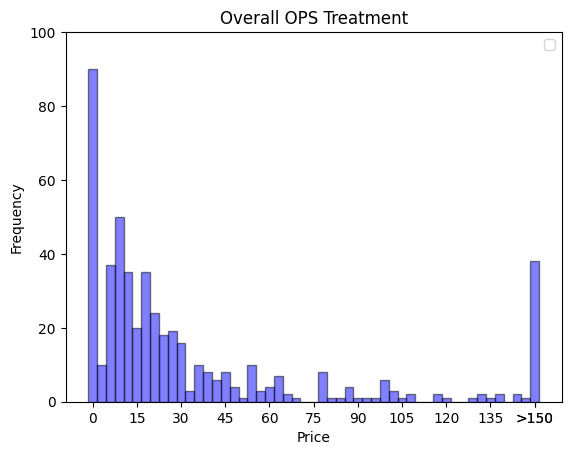

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


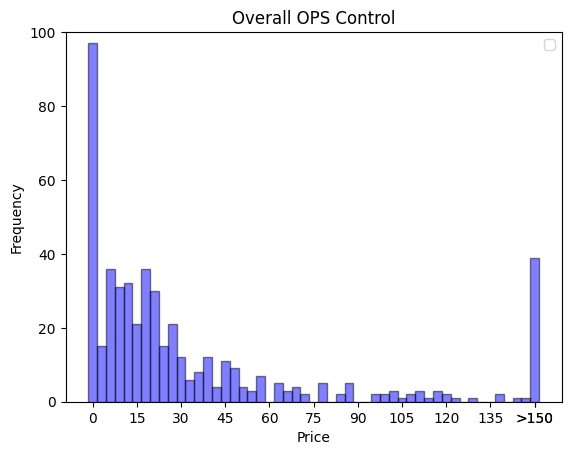

In [246]:
# plot_price_histogram([df, df[df['gender'] == 'male'], df[df['gender'] == 'female']], title="Overall OPS", xlabel="Price", ylabel="Frequency")

plot_price_histogram(
    [
        df[(df["group"] == "T1")],
    ],
    title="Overall OPS Treatment",
    ylim=(0, 100),
    filename="overall_ops_treatment.png"
)
plot_price_histogram(
    [
        df[(df["group"] == "C")],
    ],
    title="Overall OPS Control",
    ylim=(0, 100),
    filename="overall_ops_control.png"
)

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


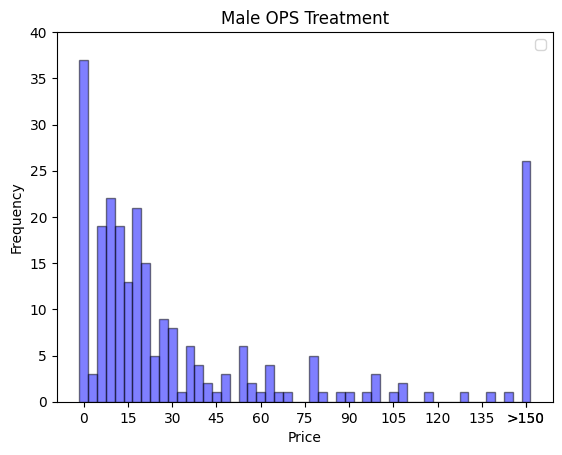

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


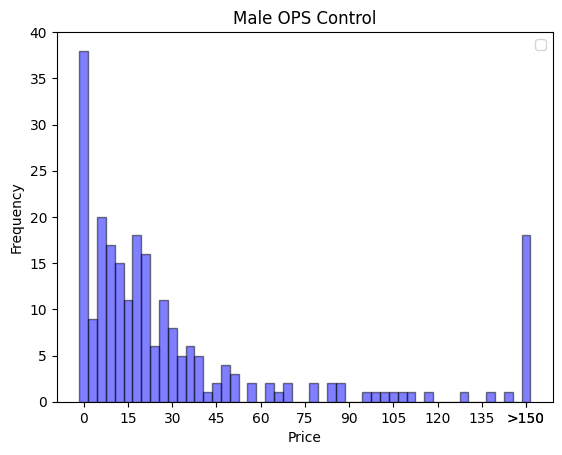

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


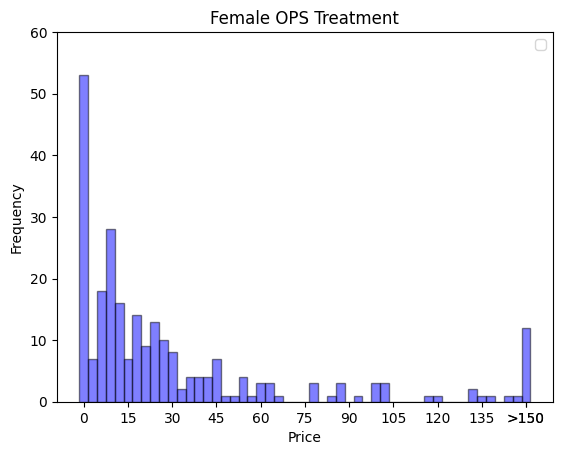

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


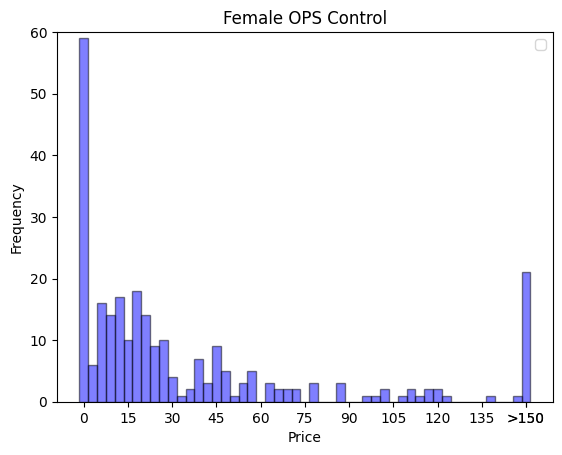

In [247]:
# 2 gender x 2 group, 4 plots

plot_price_histogram(
    df[(df["gender"] == "male") & (df["group"] == "T1")], title="Male OPS Treatment", xlabel="Price", ylabel="Frequency"
,
ylim=(0, 40),
filename="male_ops_treatment.png"
)

plot_price_histogram(
    df[(df["gender"] == "male") & (df["group"] == "C")], title="Male OPS Control", xlabel="Price", ylabel="Frequency"
,
ylim=(0, 40),
filename="male_ops_control.png"
)

plot_price_histogram(
    df[(df["gender"] == "female") & (df["group"] == "T1")], title="Female OPS Treatment", xlabel="Price", ylabel="Frequency"
,
ylim=(0, 60),
filename="female_ops_treatment.png"
)

plot_price_histogram(
    df[(df["gender"] == "female") & (df["group"] == "C")], title="Female OPS Control", xlabel="Price", ylabel="Frequency"
,
ylim=(0, 60),
filename="female_ops_control.png"
)


/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


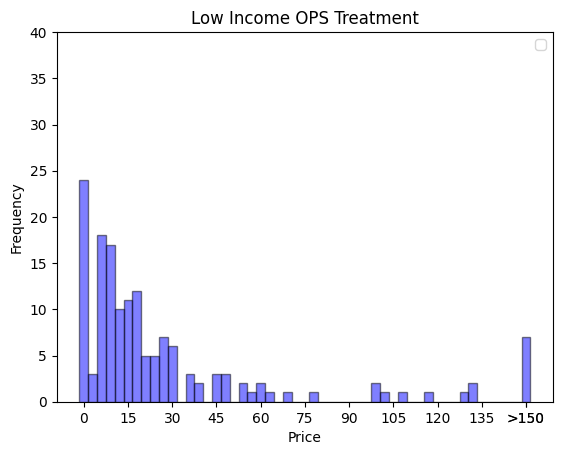

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


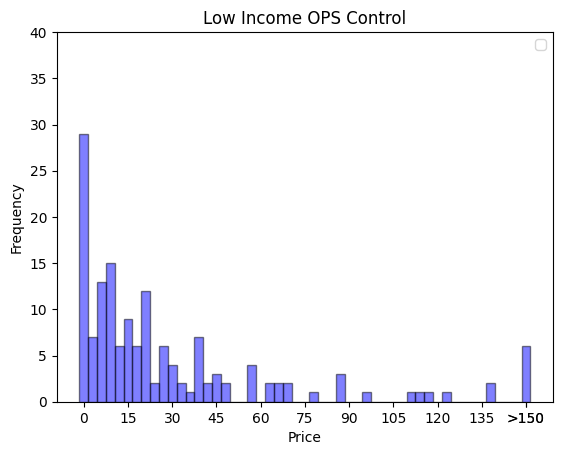

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


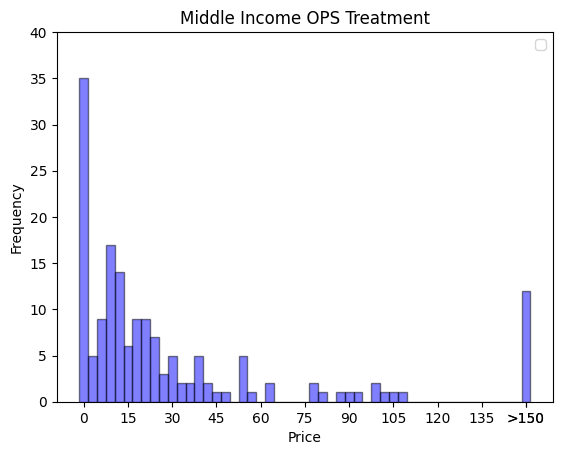

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


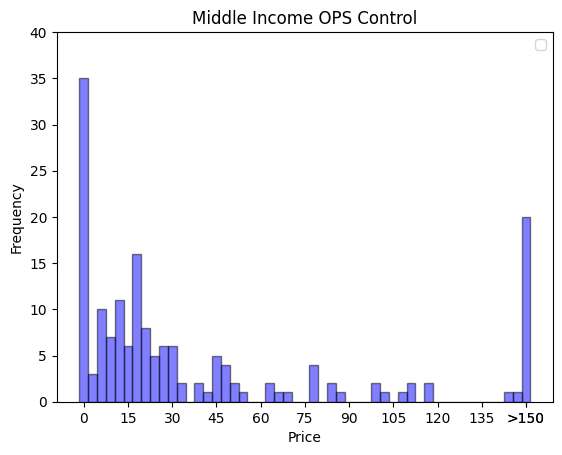

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


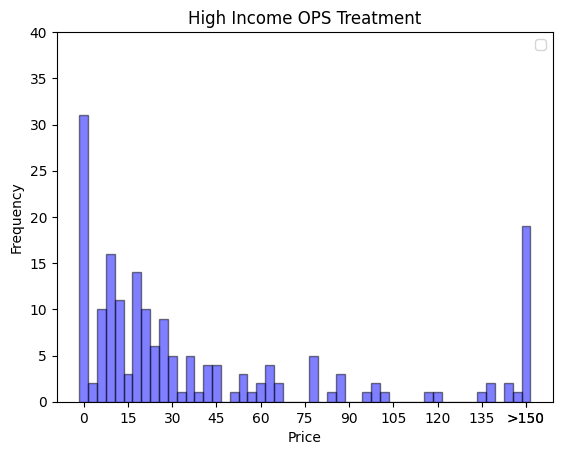

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


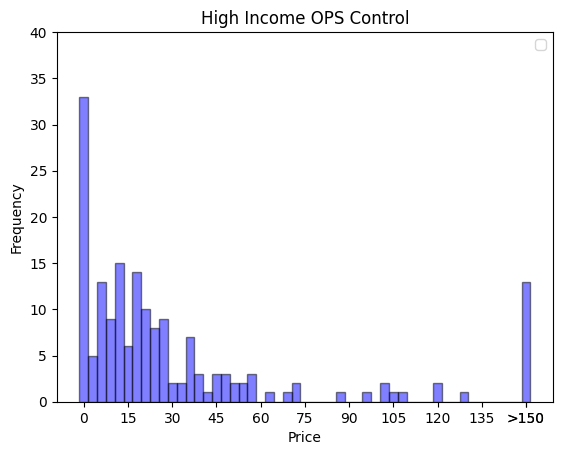

In [248]:
# 3 income x 2 group, 6 plots
plot_price_histogram(
    df[(df["income_group"] == "low") & (df["group"] == "T1")], title="Low Income OPS Treatment", xlabel="Price", ylabel="Frequency", ylim=(0, 40), filename="low_income_ops_treatment.png"
)
plot_price_histogram(
    df[(df["income_group"] == "low") & (df["group"] == "C")], title="Low Income OPS Control", xlabel="Price", ylabel="Frequency", ylim=(0, 40), filename="low_income_ops_control.png"
)
plot_price_histogram(
    df[(df["income_group"] == "middle") & (df["group"] == "T1")], title="Middle Income OPS Treatment", xlabel="Price", ylabel="Frequency", ylim=(0, 40), filename="middle_income_ops_treatment.png"
)
plot_price_histogram(
    df[(df["income_group"] == "middle") & (df["group"] == "C")], title="Middle Income OPS Control", xlabel="Price", ylabel="Frequency", ylim=(0, 40), filename="middle_income_ops_control.png"
)
plot_price_histogram(
    df[(df["income_group"] == "high") & (df["group"] == "T1")], title="High Income OPS Treatment", xlabel="Price", ylabel="Frequency", ylim=(0, 40), filename="high_income_ops_treatment.png"
)
plot_price_histogram(
    df[(df["income_group"] == "high") & (df["group"] == "C")], title="High Income OPS Control", xlabel="Price", ylabel="Frequency", ylim=(0, 40), filename="high_income_ops_control.png"
)

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


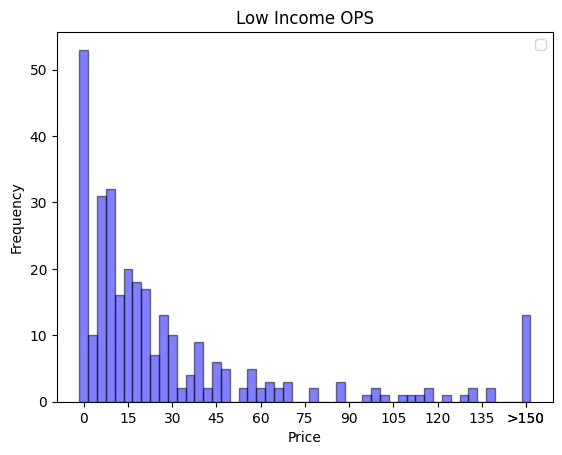

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


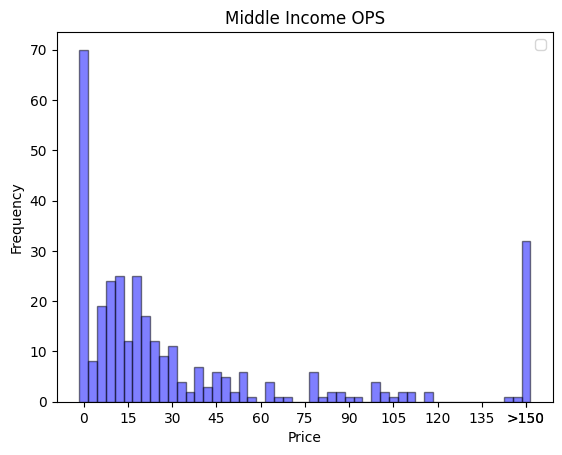

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


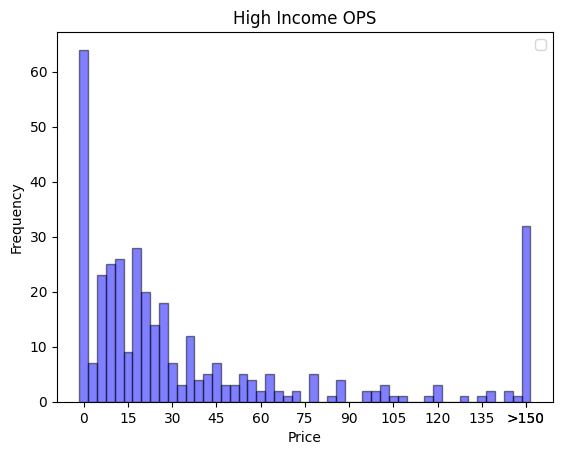

In [249]:
plot_price_histogram(
    df[df["income_group"] == "low"], title="Low Income OPS", xlabel="Price", ylabel="Frequency"
)
plot_price_histogram(
    df[df["income_group"] == "middle"], title="Middle Income OPS", xlabel="Price", ylabel="Frequency"
)
plot_price_histogram(
    df[df["income_group"] == "high"], title="High Income OPS", xlabel="Price", ylabel="Frequency"
)


In [250]:
from scipy.stats import ttest_ind

# Calculate mean and standard deviation for treatment and control groups
treatment_mean = df[df["group"] == "T1"]["price"].mean()
treatment_std = df[df["group"] == "T1"]["price"].std()
control_mean = df[df["group"] == "C"]["price"].mean()
control_std = df[df["group"] == "C"]["price"].std()

# Perform t-test
t_stat, p_value = ttest_ind(
    df[df["group"] == "T1"]["price"],
    df[df["group"] == "C"]["price"],
    equal_var=False
)

# Format the output
formatted_output = (
    f"Ops. in Control: avg. = ${control_mean:.3f}, s.d. = ${control_std:.2f}; \n"
    f"Ops. in Treatment: avg. = ${treatment_mean:.3f}, s.d. = ${treatment_std:.2f}; \n"
    f"t({len(df[df['group'] == 'T1']) + len(df[df['group'] == 'C']) - 2}) = {t_stat:.3f}, p={p_value:.3f}"
)

print(formatted_output)


Ops. in Control: avg. = $55.144, s.d. = $154.69; 
Ops. in Treatment: avg. = $63.973, s.d. = $295.73; 
t(998) = 0.592, p=0.554


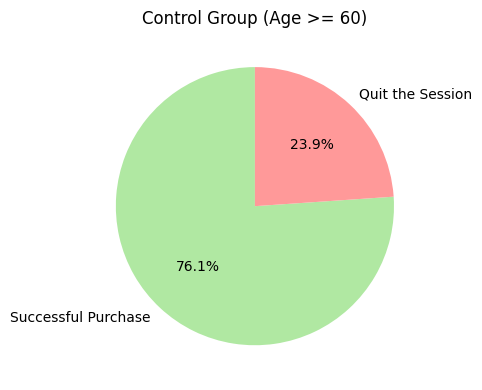

In [285]:
import matplotlib.pyplot as plt
filtered_df = df[~df["error"] & (df['age'] >= 60)]
# Prepare data for pie chart
treatment_terminated_counts = filtered_df[filtered_df["group"] == "T1"][
    "terminated"
].value_counts()
control_terminated_counts = filtered_df[filtered_df["group"] == "C"][
    "terminated"
].value_counts()

# Plot pie chart for treatment group
plt.figure(figsize=(8, 4))

# Plot pie chart for control group
# plt.subplot(1, 2, 1)
plt.pie(
    control_terminated_counts,
    labels=["Successful Purchase", "Quit the Session"],
    autopct="%1.1f%%",
    startangle=90,
    # light green
    colors=["#b0e8a2", "#ff9999"],
)
plt.title("Control Group (Age >= 60)")

plt.tight_layout()
plt.savefig("control_65.png")
plt.show()


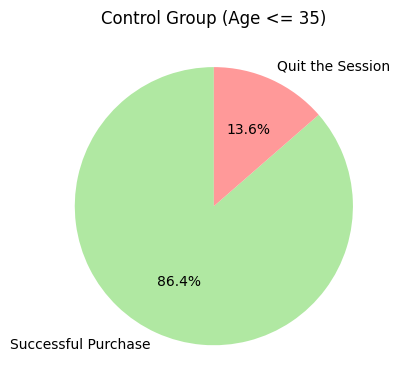

In [286]:
import matplotlib.pyplot as plt

filtered_df = df[~df["error"] & (df["age"] <= 35)]
# Prepare data for pie chart
treatment_terminated_counts = filtered_df[filtered_df["group"] == "T1"][
    "terminated"
].value_counts()
control_terminated_counts = filtered_df[filtered_df["group"] == "C"][
    "terminated"
].value_counts()

# Plot pie chart for treatment group
plt.figure(figsize=(8, 4))

# Plot pie chart for control group
# plt.subplot(1, 2, 1)
plt.pie(
    control_terminated_counts,
    labels=["Successful Purchase", "Quit the Session"],
    autopct="%1.1f%%",
    startangle=90,
    # light green
    colors=["#b0e8a2", "#ff9999"],
)
plt.title("Control Group (Age <= 35)")

plt.tight_layout()
plt.savefig("control_35.png")
plt.show()


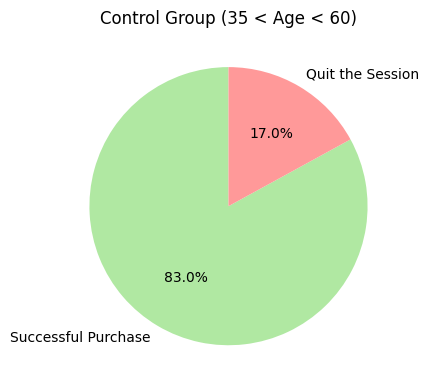

In [287]:
import matplotlib.pyplot as plt

filtered_df = df[~df["error"] & (df["age"] > 35) & (df["age"] < 60)]
# Prepare data for pie chart
treatment_terminated_counts = filtered_df[filtered_df["group"] == "T1"][
    "terminated"
].value_counts()
control_terminated_counts = filtered_df[filtered_df["group"] == "C"][
    "terminated"
].value_counts()

# Plot pie chart for treatment group
plt.figure(figsize=(8, 4))

# Plot pie chart for control group
# plt.subplot(1, 2, 1)
plt.pie(
    control_terminated_counts,
    labels=["Successful Purchase", "Quit the Session"],
    autopct="%1.1f%%",
    startangle=90,
    # light green
    colors=["#b0e8a2", "#ff9999"],
)
plt.title("Control Group (35 < Age < 60)")

plt.tight_layout()
plt.savefig("control_35_65.png")
plt.show()


In [104]:
# chi square
from scipy.stats import chisquare

chisquare(
    [
        sum(df[df["group"] == "C"]["terminated"].astype(bool)),
        500 - sum(df[df["group"] == "C"]["terminated"].astype(bool)),
    ],
    [
        sum(df[df["group"] == "T1"]["terminated"].astype(bool)),
        500 - sum(df[df["group"] == "T1"]["terminated"].astype(bool)),
    ],
)


Power_divergenceResult(statistic=np.float64(8.03560578442095), pvalue=np.float64(0.004586666814499163))

In [105]:

# X2 (degress of freedom, N = sample size) = chi-square statistic value, p = p value.
chi_square_result = chisquare(
    [
        sum(df[df["group"] == "C"]["terminated"].astype(bool)),
        500 - sum(df[df["group"] == "C"]["terminated"].astype(bool)),
    ],
    [
        sum(df[df["group"] == "T1"]["terminated"].astype(bool)),
        500 - sum(df[df["group"] == "T1"]["terminated"].astype(bool)),
    ],
)

formatted_output = (
    f"X^2 (df={len(df) - 1}, N={len(df)}) = {chi_square_result.statistic:.2f}, "
    f"p = {chi_square_result.pvalue:.3f}"
)
print(formatted_output)


X^2 (df=999, N=1000) = 8.04, p = 0.005


In [253]:
treatment_terminated_counts


terminated
False    445
True      55
Name: count, dtype: int64

In [272]:
print(df[df["income_group"] == "low"]['price'].mean())
print(df[df["income_group"] == "middle"]["price"].mean())
print(df[df["income_group"] == "high"]["price"].mean())


34.712622950819664
62.73080838323352
77.6147922437673


In [271]:
df[df["income_group"] == "middle"]["price"]

0       32.99
1       13.99
5        7.89
8        0.00
12      50.00
        ...  
988     34.99
989    587.98
994    112.35
995    106.24
996     16.48
Name: price, Length: 334, dtype: float64

In [9]:
df.to_excel("data/result.xlsx")

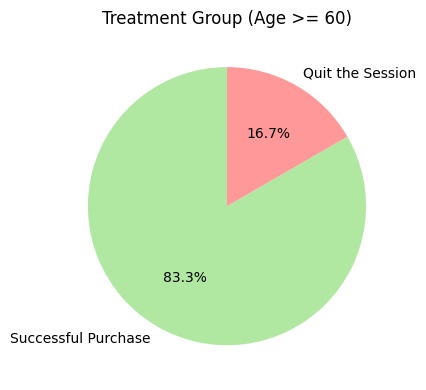

In [288]:
import matplotlib.pyplot as plt

filtered_df = df[~df["error"] & (df["age"] >= 60)]
# Prepare data for pie chart
treatment_terminated_counts = filtered_df[filtered_df["group"] == "T1"][
    "terminated"
].value_counts()

# Plot pie chart for treatment group
plt.figure(figsize=(8, 4))

# Plot pie chart for control group
# plt.subplot(1, 2, 1)
plt.pie(
    treatment_terminated_counts,
    labels=["Successful Purchase", "Quit the Session"],
    autopct="%1.1f%%",
    startangle=90,
    # light green
    colors=["#b0e8a2", "#ff9999"],
)
plt.title("Treatment Group (Age >= 60)")

plt.tight_layout()
plt.savefig("treatment_65.png")
plt.show()


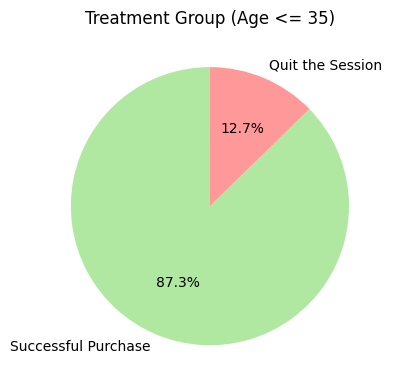

In [289]:
import matplotlib.pyplot as plt

filtered_df = df[~df["error"] & (df["age"] <= 35)]
# Prepare data for pie chart
treatment_terminated_counts = filtered_df[filtered_df["group"] == "T1"][
    "terminated"
].value_counts()

# Plot pie chart for treatment group
plt.figure(figsize=(8, 4))

# Plot pie chart for control group
# plt.subplot(1, 2, 1)
plt.pie(
    treatment_terminated_counts,
    labels=["Successful Purchase", "Quit the Session"],
    autopct="%1.1f%%",
    startangle=90,
    # light green
    colors=["#b0e8a2", "#ff9999"],
)
plt.title("Treatment Group (Age <= 35)")

plt.tight_layout()
plt.savefig("treatment_35.png")
plt.show()


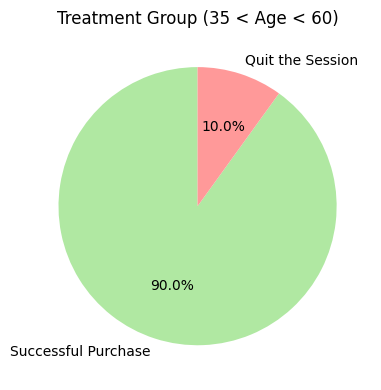

In [290]:
import matplotlib.pyplot as plt

filtered_df = df[~df["error"] & (df["age"] > 35) & (df["age"] < 60)]
# Prepare data for pie chart
treatment_terminated_counts = filtered_df[filtered_df["group"] == "T1"][
    "terminated"
].value_counts()

# Plot pie chart for treatment group
plt.figure(figsize=(8, 4))

# Plot pie chart for control group
# plt.subplot(1, 2, 1)
plt.pie(
    treatment_terminated_counts,
    labels=["Successful Purchase", "Quit the Session"],
    autopct="%1.1f%%",
    startangle=90,
    # light green
    colors=["#b0e8a2", "#ff9999"],
)
plt.title("Treatment Group (35 < Age < 60)")

plt.tight_layout()
plt.savefig("treatment_35_60.png")
plt.show()


In [291]:
df.to_excel("data/result.xlsx")

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


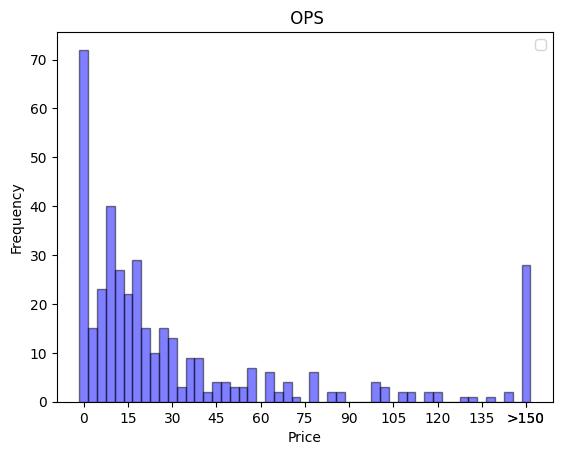

In [292]:
plot_price_histogram(
    df[df["age"] < 35],
    title=" OPS",
    xlabel="Price",
    ylabel="Frequency",
)

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


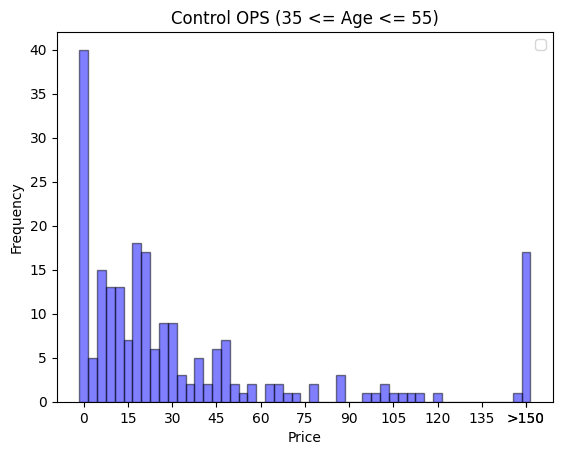

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


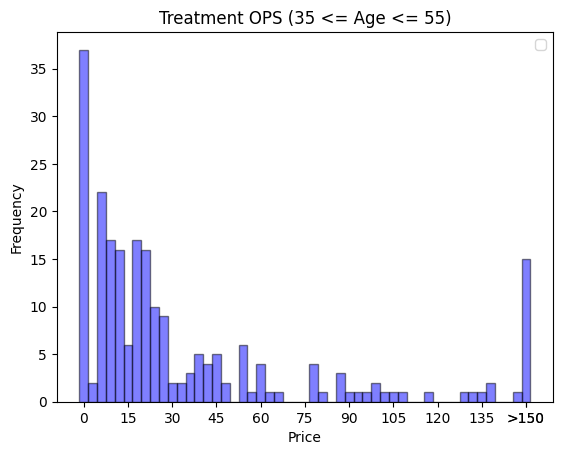

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


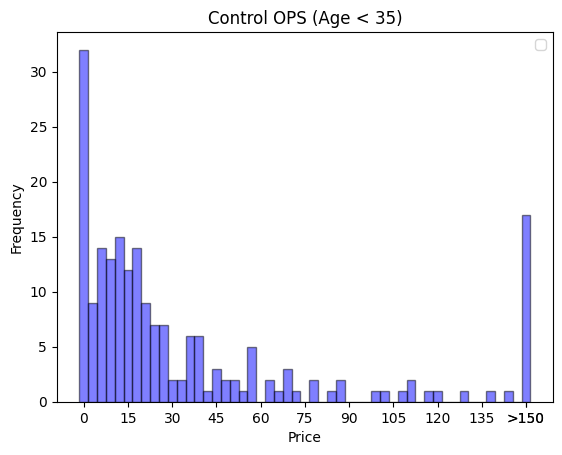

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


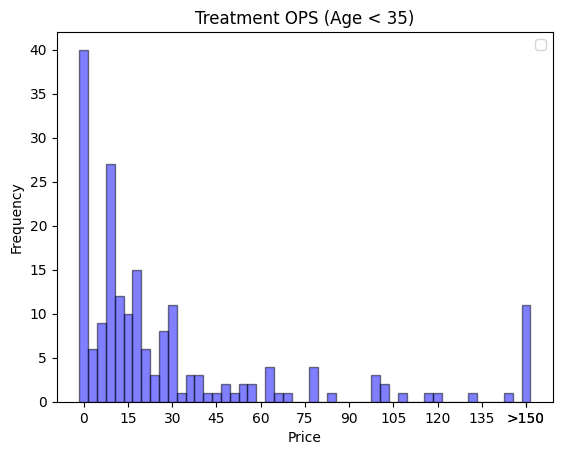

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


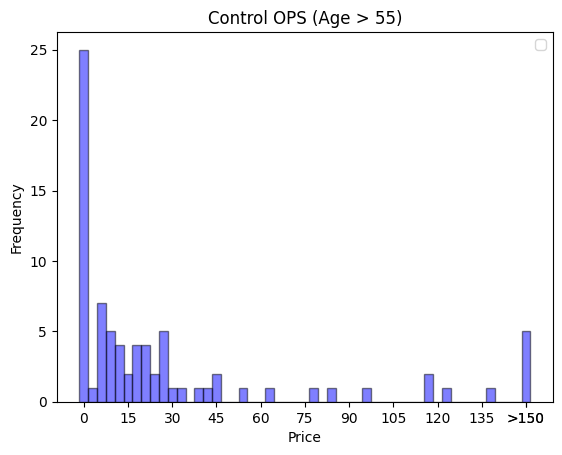

/var/folders/x1/scdkv1c92yl645n03b3lbvj00000gq/T/ipykernel_66305/2787081444.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


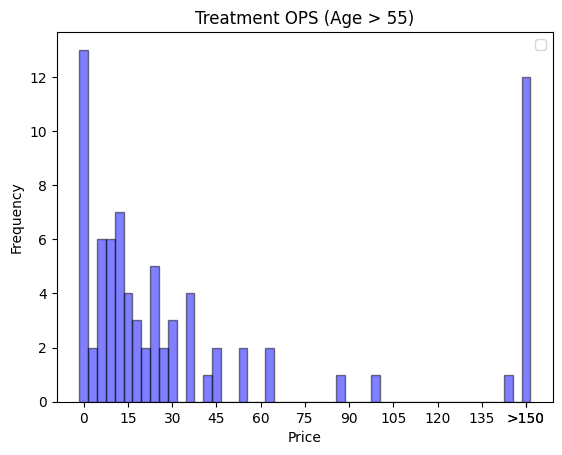

In [298]:
plot_price_histogram(
    df[(df["age"] >= 35) & (df["age"] <= 55) & (df["group"] == "C")],
    title="Control OPS (35 <= Age <= 55)",
    xlabel="Price",
    ylabel="Frequency",
    filename="control_35_55.png"
)

plot_price_histogram(
    df[(df["age"] >= 35) & (df["age"] <= 55) & (df["group"] == "T1")],
    title="Treatment OPS (35 <= Age <= 55)",
    xlabel="Price",
    ylabel="Frequency",
    filename="treatment_35_55.png"
)

plot_price_histogram(
    df[(df["age"] < 35) & (df["group"] == "C")],
    title="Control OPS (Age < 35)",
    xlabel="Price",
    ylabel="Frequency",
    filename="control_35.png"
)

plot_price_histogram(
    df[(df["age"] < 35) & (df["group"] == "T1")],
    title="Treatment OPS (Age < 35)",
    xlabel="Price",
    ylabel="Frequency",
    filename="treatment_35.png"
)

plot_price_histogram(
    df[(df["age"] > 55) & (df["group"] == "C")],
    title="Control OPS (Age > 55)",
    xlabel="Price",
    ylabel="Frequency",
    filename="control_55.png"
)

plot_price_histogram(
    df[(df["age"] > 55)& (df["group"] == "T1")],
    title="Treatment OPS (Age > 55)",
    xlabel="Price",
    ylabel="Frequency",
    filename="treatment_55.png"
)


In [294]:
print(df[(df["age"] >= 35) & (df["age"] <= 55)]['price'].mean())

64.68632286995515


In [295]:
print(df[(df["age"] < 35)]["price"].mean())


53.741212121212115


['departments', 'departments', 'reviews_refinements']